In [38]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [39]:
df = pd.read_csv(r'C:\Users\91783\Desktop\TSA\Bhiwadi1.csv')

In [40]:
df.head()

,Date,PM2.5
0,2021-01-01,228.53
1,2021-01-02,222.37
2,2021-01-03,128.14
3,2021-01-04,68.44
4,2021-01-05,62.51


In [41]:
df['Date'] = pd.to_datetime(df['Date'])

In [42]:
df.head()

,Date,PM2.5
0,2021-01-01,228.53
1,2021-01-02,222.37
2,2021-01-03,128.14
3,2021-01-04,68.44
4,2021-01-05,62.51


In [43]:
y = pd.Series(data=df['PM2.5'].values, index=df['Date'])

In [44]:
y.head()

Date
2021-01-01    228.53
2021-01-02    222.37
2021-01-03    128.14
2021-01-04     68.44
2021-01-05     62.51
dtype: float64

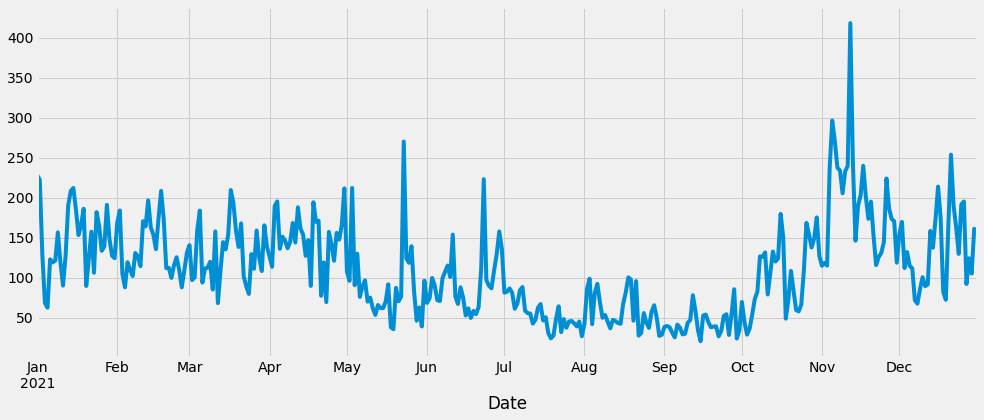

In [45]:
y.plot(figsize=(15, 6))
plt.show()

In [46]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [47]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
            
print('\nBest Result:', best_result)

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 4549.710802289167
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC: 4185.4306505951545
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC: 3907.8260557900676
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC: 3697.146763531147
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC: 3900.6513292069885
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC: 3828.2426636181312
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC: 3733.2619527680713
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC: 3698.9291984147394
ARIMA(0, 0, 1) x (0, 0, 0, 12) - AIC: 4204.978568968923
ARIMA(0, 0, 1) x (0, 0, 1, 12) - AIC: 3941.694048304621
ARIMA(0, 0, 1) x (0, 1, 0, 12) - AIC: 3793.5356166037905
ARIMA(0, 0, 1) x (0, 1, 1, 12) - AIC: 3555.913073142364
ARIMA(0, 0, 1) x (1, 0, 0, 12) - AIC: 3783.1803266637753
ARIMA(0, 0, 1) x (1, 0, 1, 12) - AIC: 3683.4237602381695
ARIMA(0, 0, 1) x (1, 1, 0, 12) - AIC: 3616.1716990988516
ARIMA(0, 0, 1) x (1, 1, 1, 12) - AIC: 3557.8563324611414
ARIMA(0, 1, 0) x (0, 0, 0, 12) - AIC: 3730.1549094255242
ARIMA(0, 1, 0) x (0, 0, 1, 12) - AIC

In [48]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(best_result[0][0], best_result[0][1], best_result[0][1]),
                                seasonal_order=(best_result[1][0], best_result[1][1], best_result[1][2], best_result[1][3]),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4027      0.055      7.282      0.000       0.294       0.511
ma.L1         -0.8558      0.031    -27.596      0.000      -0.917      -0.795
ma.S.L12      -1.0000      0.040    -25.129      0.000      -1.078      -0.922
sigma2      1376.9154   2.89e-05   4.76e+07      0.000    1376.915    1376.915


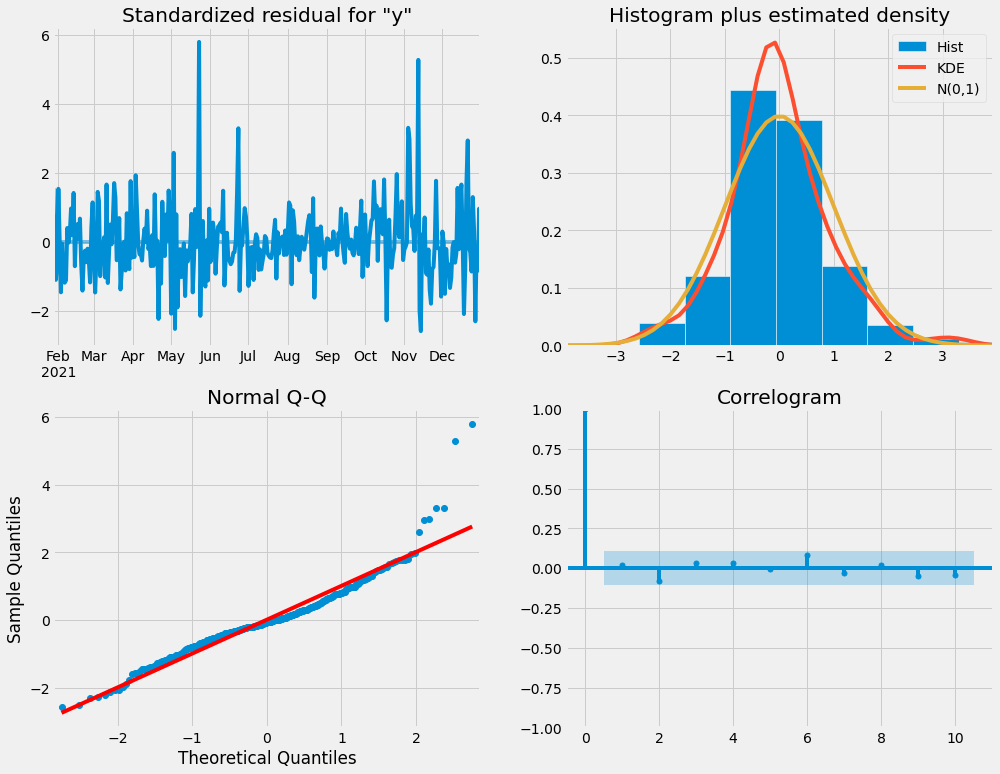

In [49]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [50]:
pred = results.get_prediction(start=pd.to_datetime('2021-09-01'), dynamic=False)
pred_ci = pred.conf_int()

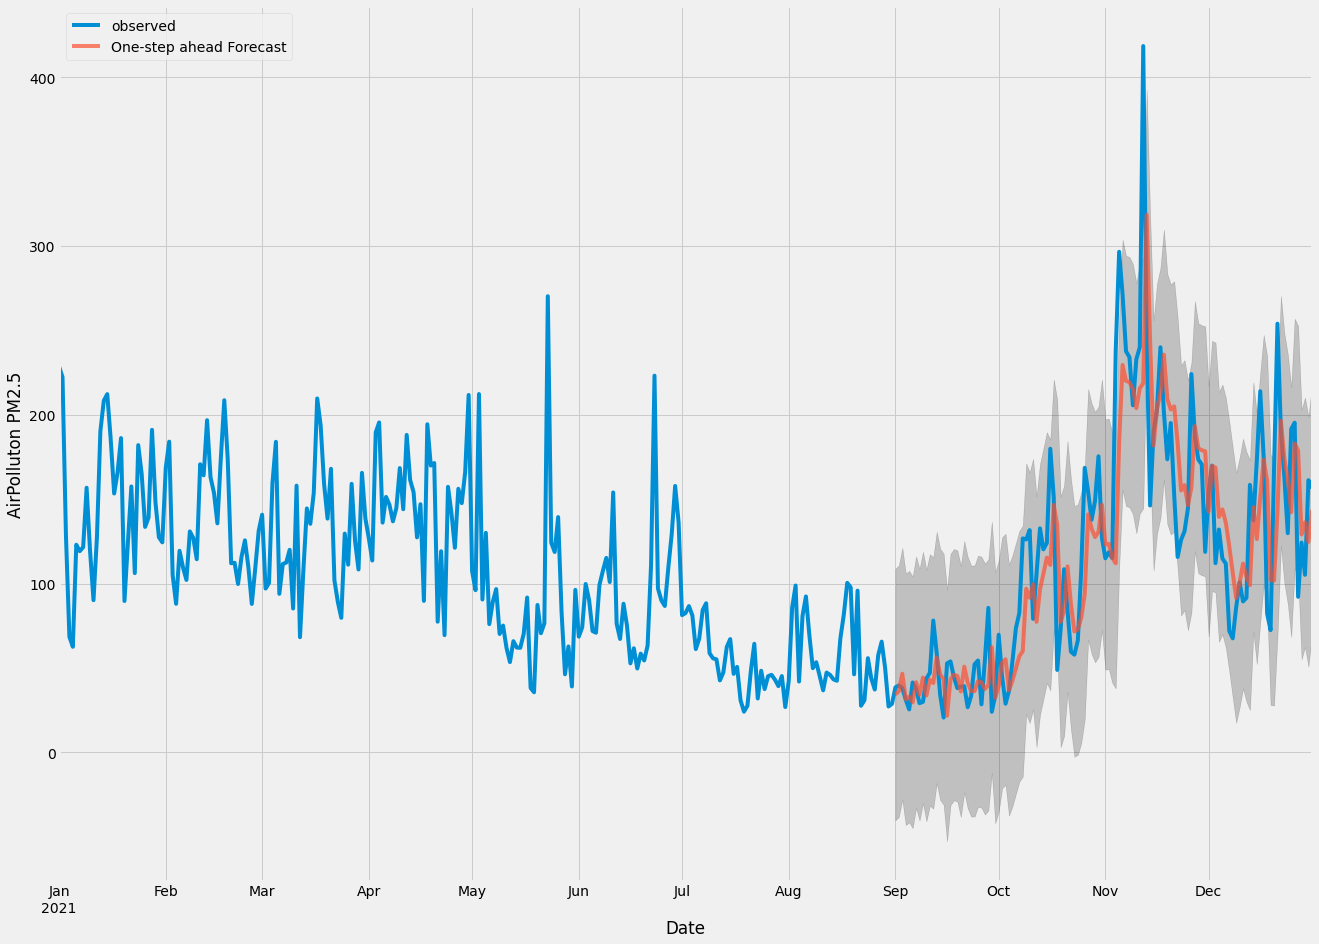

In [51]:
ax = y['2021':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('AirPolluton PM2.5')
plt.legend()

plt.show()

In [52]:
# Extract the predicted and true values of our time series
y_forecasted = pred.predicted_mean
y_truth = y['2021-09-01':]


# Accuracy metrics
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
mape = np.mean(np.abs(y_forecasted - y_truth)/np.abs(y_truth))
print('MAPE')
print(mape)    
me = np.mean(y_forecasted - y_truth)
print('ME')
print(me)
mae = np.mean(np.abs(y_forecasted - y_truth))    # MAE
print('MAE')
print(mae)
mpe = np.mean((y_forecasted - y_truth)/y_truth)   # MPE
print('MPE')
print(mpe)
rmse = np.mean((y_forecasted - y_truth)**2)**.5  # RMSE
print('RMSE')
print(rmse)
corr = np.corrcoef(y_forecasted,y_truth)[0,1]   # corr
print('Corr')
print(corr)

The Mean Squared Error of our forecasts is 1722.04
MAPE
0.27198007885453496
ME
-3.919794925602803
MAE
28.04610701869396
MPE
0.052515982995026106
RMSE
41.4974205422377
Corr
0.8199934465488712


In [53]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2021-09-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

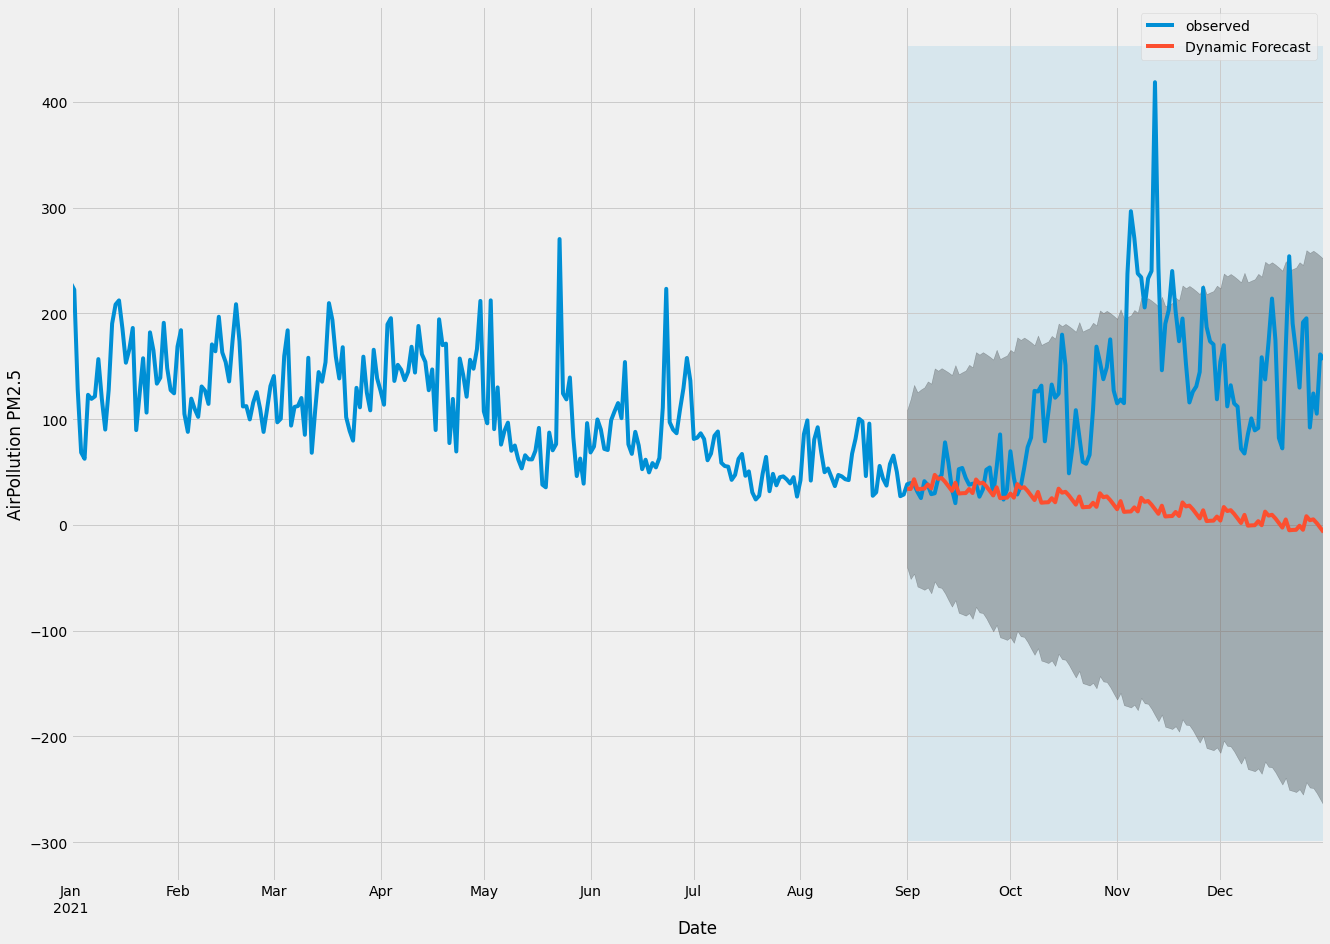

In [54]:
ax = y['1949':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-09-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('AirPollution PM2.5')

plt.legend()
plt.show()

In [55]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2021-09-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
mape = np.mean(np.abs(y_forecasted - y_truth)/np.abs(y_truth))
print('MAPE')
print(mape)    
me = np.mean(y_forecasted - y_truth)
print('ME')
print(me)
mae = np.mean(np.abs(y_forecasted - y_truth))    # MAE
print('MAE')
print(mae)
mpe = np.mean((y_forecasted - y_truth)/y_truth)   # MPE
print('MPE')
print(mpe)
rmse = np.mean((y_forecasted - y_truth)**2)**.5  # RMSE
print('RMSE')
print(rmse)
corr = np.corrcoef(y_forecasted,y_truth)[0,1]   # corr
print('Corr')
print(corr)

The Mean Squared Error of our forecasts is 16321.86
MAPE
0.716097375343149
ME
-99.79089640293375
MAE
101.32003985842839
MPE
-0.6595426374875479
RMSE
127.75704630134372
Corr
-0.5394661583796334


In [56]:
# Get forecast 24 steps ahead in future
pred_uc = results.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

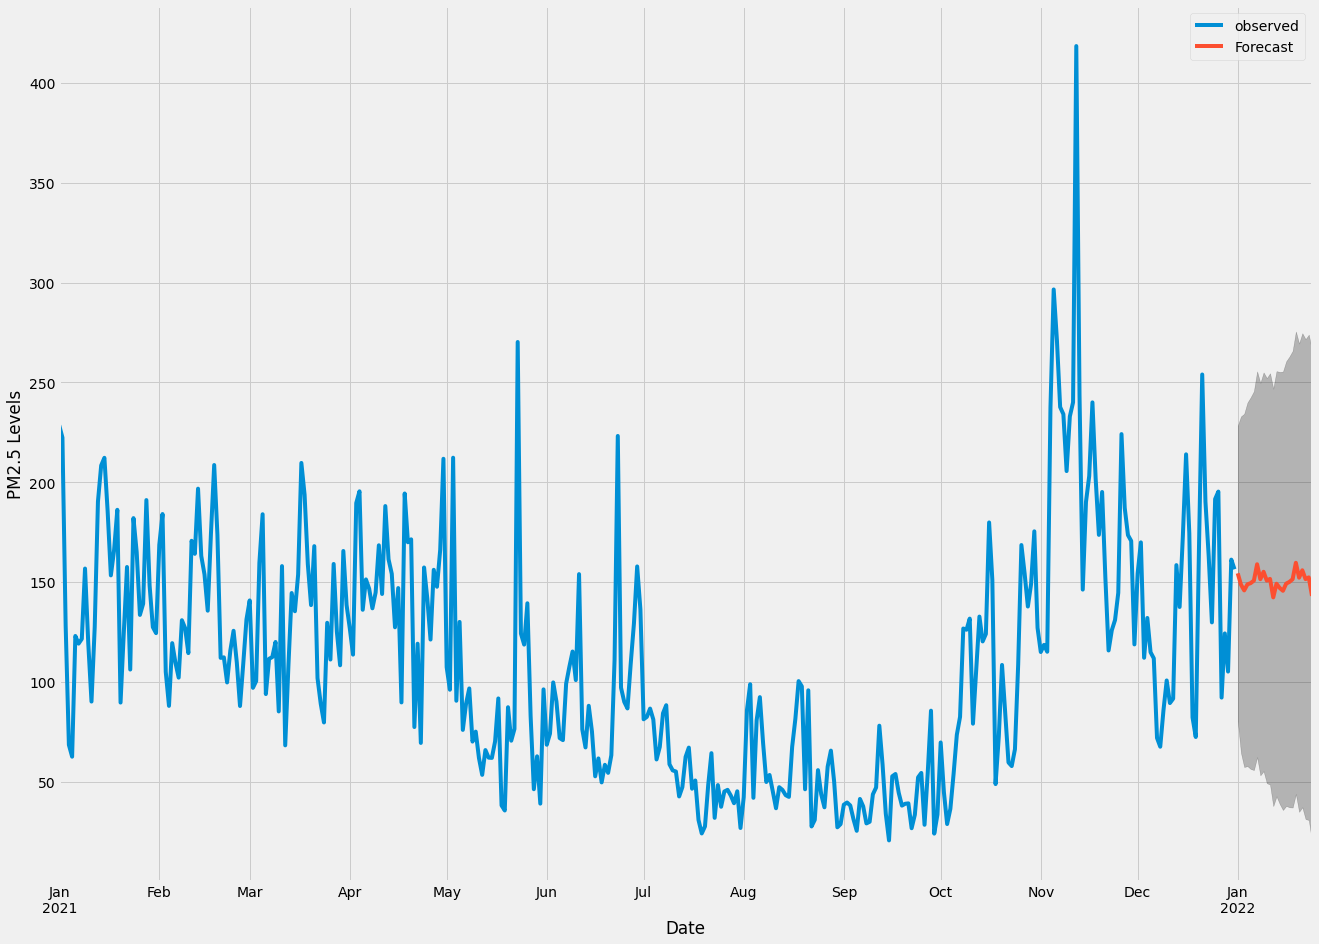

In [57]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5 Levels')

plt.legend()
plt.show()